In [3]:
import sys
sys.path.append('../code')
import utils, spike_train_functions, lfp_functions

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pd
from bycycle import BycycleGroup
from bycycle.utils import get_extrema_df

from scipy.stats import wasserstein_distance
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import seaborn as sns


In [4]:
data_path = '../data/'
session_files = {
    'SPK121107_MI_PMd_TT_NOGO_ob001': {
        'event_file': 'ev_explicit.mat',
        'unit_file': 'DSXII-SORTED-01_gNTSNR.mat',
        'lfp_file': '30x_downsample.mat',
        'map_file': 'SPK_map_MI_PMd.mat'},
    # 'SPK121107_PMv_TT_NOGO_ob001': {
    #     'event_file': 'ev_explicit.mat',
    #     'unit_file': 'DSXII-SORTED-02_gNTSNR.mat',
    #     'lfp_file': '30x_downsample.mat'},
    'RUSRH120619_MI_PMd_TT_KG_TC_NOGO_Ob001': {
        'event_file': 'ev_explicit.mat',
        'unit_file': 'DSXI_corrected_gNTSNR_split.mat',
        'lfp_file': '30x_downsample.mat',
        'map_file': 'RUS_map_MI_PMd.mat'},
    
}

In [30]:
def process_session(session_name, session_dict):
    # Loading files for specific recording session
    # ============================================
    
    # Load spiking data and electrode map
    fpath = f'../data/{session_name}'
    unit_fname = f'{fpath}/{session_name}_{session_dict["unit_file"]}'

    event_fname = f'{fpath}/{session_name}_{session_dict["event_file"]}'
    lfp_fname = f'{fpath}/{session_name}_{session_dict["lfp_file"]}'
    map_fname = f'../data/{session_dict["map_file"]}'
    
    # Load electrode map, single unit spiking, and LFP (.nsx), and experiment data
    mapping_dict = sio.loadmat(map_fname)
    single_unit_dict = sio.loadmat(unit_fname)
    nsx_dict = sio.loadmat(lfp_fname)
    experiment_dict = utils.load_cgid_ev_explicit(event_fname)
    
    # Process electrode map
    emap_dict = {'label_idx': np.stack(mapping_dict['map_struct'][0]['Num']).squeeze() - 1,
               'row': np.stack(mapping_dict['map_struct'][0]['Row']).squeeze(),
               'col': np.stack(mapping_dict['map_struct'][0]['Column']).squeeze(),
               'area': np.stack(mapping_dict['map_struct'][0]['SubArrayName']).squeeze()}
    emap_df_full = pd.DataFrame(emap_dict)

    # Process single unit data
    single_unit_dict = sio.loadmat(unit_fname)

    sorted_timestamps = single_unit_dict['sorted_timestamps'][0]
    unit_timestamps = [sorted_timestamps[unit_idx].squeeze() for unit_idx in range(len(sorted_timestamps))]
    num_units = len(unit_timestamps)
    unit_names = np.array(range(num_units))

    unit_electrodes = single_unit_dict['unit_index'][0,:] - 1
    unit_areas = [emap_df_full['area'].values[elec_idx] for elec_idx in unit_electrodes]
    
    # Process experiment timestamps
    go = experiment_dict['go']
    stmv = experiment_dict['stmv']
    contact = experiment_dict['contact']
    obpres = experiment_dict['obpres']
    obj = experiment_dict['ob']
    grip = experiment_dict['grip']

    
    # Process LFP data
    # ================
    samp_freq = 1000
    nsx_duration = nsx_dict['out'][0][0]['MetaTags'][0][0]['DataDurationSec']

    lfp_data_raw = nsx_dict['out'][0][0]['Data']
    lfp_times_raw = np.linspace(0, nsx_duration, lfp_data_raw.shape[1]).squeeze()
    
    lfp_corr = np.corrcoef(lfp_data_raw)

    win_start = -2.5
    win_len = 2

    # event_dict = {'go': go}
    # window_dict = {'pre': (win_start, win_len)}

    # event_dict = {'grasppres':grasppres, 'obpres': obpres}
    event_dict = {'go': go}
    window_dict = {'pre': (win_start, win_len)}


    lfp_data_col = list()
    event_col, event_times_col, window_col, tstart_col = list(), list(), list(), list()
    trial_col, object_col, grip_col = list(), list(), list()

    for window_name, (st_offset, max_time) in window_dict.items():
        max_samples = int(max_time * samp_freq)
        for event_name, event_ts in event_dict.items():
            object_col.extend(obj)
            grip_col.extend(grip)
            for trial_idx, event_time in enumerate(event_ts):
                    event_col.append(event_name)
                    event_times_col.append(event_time)
                    window_col.append(window_name)
                    trial_col.append(trial_idx)

                    tstart = event_time + st_offset
                    tstop = tstart + max_time
                    start_idx = np.argmin(np.abs(lfp_times_raw - tstart))
                    stop_idx = start_idx + max_samples

                    tstart_col.append(tstart)

                    lfp_windowed = lfp_data_raw[:, start_idx:stop_idx]
                    lfp_data_col.append(lfp_windowed)


    lfp_dict = {'event': event_col, 'window': window_col, 'lfp': lfp_data_col, 'event_time': event_times_col,
                'object': object_col,
                'grip': grip_col, 'trial': trial_col, 'tstart': tstart_col}

    lfp_df = pd.DataFrame(lfp_dict)

    # Extract beta oscillations with cycle by cycle analysis
    # ======================================================
    lfp_data_array = np.stack(lfp_df['lfp'].values)

    num_trial_segs, num_channels, num_times = lfp_data_array.shape
    trial_idx_map = lfp_df['trial'].values # Need to grap actual trial indices
    tstart_map = lfp_df['tstart'].values
    event_map = lfp_df['event'].values
    window_map = lfp_df['window'].values

    x_times = np.linspace(0, num_times / samp_freq, num_times)
    
    bycycle_lfp_array = np.transpose(lfp_data_array, (1,0,2))
    fs = samp_freq
    f_beta = (12,30)
    n_seconds_beta = 0.75

    # **May need to adjust these thresholds*
    thresholds = {'amp_fraction': 0.5, 'amp_consistency': .5, 'period_consistency': .4, 
                  'monotonicity': .5, 'min_n_cycles': 2}

    compute_kwargs = {'burst_method': 'cycles', 'threshold_kwargs': thresholds, 'center_extreme': 'trough'}


    bg = BycycleGroup(thresholds=thresholds)
    bg.fit(bycycle_lfp_array, fs, f_beta, axis=0, progress='tqdm')

    # Combine by cycle analysis for all electrodes into dataframe
    bg_df_list = list()
    assert len(bg.df_features) == num_channels
    for channel_idx in range(num_channels):
        assert len(bg.df_features[channel_idx]) == num_trial_segs
        for trial_seg_idx in range(num_trial_segs):
            trial_idx = trial_idx_map[trial_seg_idx]
            trial_tstart = tstart_map[trial_seg_idx]
            event_name = event_map[trial_seg_idx]
            window_name = window_map[trial_seg_idx]


            temp_df = bg.df_features[channel_idx][trial_seg_idx].copy()
            temp_df['channel'] = np.repeat(channel_idx, len(temp_df))
            temp_df['trial'] = np.repeat(trial_idx, len(temp_df))
            temp_df['tstart'] = np.repeat(tstart, len(temp_df))
            temp_df['event'] = np.repeat(event_name, len(temp_df))
            temp_df['window'] = np.repeat(window_name, len(temp_df))
            temp_df['trial_seg'] = np.repeat(trial_seg_idx, len(temp_df))
            temp_df['grip'] = np.repeat(grip[trial_idx], len(temp_df))
            temp_df['object'] = np.repeat(obj[trial_idx], len(temp_df))

            bg_df_list.append(temp_df)

    bg_df = pd.concat(bg_df_list)

    bg_df.to_pickle(f'{fpath}/{session_name}_bycycle_df.pkl')
    
    noise_channels = np.where(np.mean(lfp_corr,axis=0) < 0.2)[0]
    bg_df = bg_df[~np.isin(bg_df['channel'], noise_channels)]
    clean_channels = bg_df['channel'].unique()
    
    # Extract spiking data aligned to beta troughs
    
    filter_df = bg_df.copy()
    filter_df['sample_peak'] = (filter_df['sample_peak'] / fs) + filter_df['tstart']
    filter_df['sample_last_trough'] = (filter_df['sample_last_trough'] / fs) + filter_df['tstart']
    filter_df['sample_next_trough'] = (filter_df['sample_next_trough'] / fs) + filter_df['tstart']
    filter_df = filter_df.dropna(axis=0)

    
    # ** NEED TO SET THRESHOLDS**
    filter_df = filter_df[filter_df['is_burst']]
    # filter_df = filter_df[filter_df['band_amp'] > 15]

    wstart, wstop = -0.2, 0.2
    
    electrode_df = filter_df.copy()
    electrode_idx = clean_channels[10]  # this is really an arbitrary choice
    electrode_df = electrode_df[electrode_df['channel']==electrode_idx]

    # Extract event ts for each electrode
    event_ts = electrode_df['sample_next_trough']

    # Filter spike times to event ts
    st_data = spike_train_functions.st_window_split(
        unit_timestamps, event_ts, wstart=wstart, wstop=wstop)

    st_data_go = spike_train_functions.st_window_split(
        unit_timestamps, go, wstart=wstart, wstop=wstop)

    st_data_stmv = spike_train_functions.st_window_split(
        unit_timestamps, stmv, wstart=wstart, wstop=wstop)

    # Alternative filtering based on electrode used to record spike
    
#     st_data, st_data_go, st_data_stmv = list(), list(), list()
#     st_data_obpres, st_data_grasppres = list(), list()
#     for electrode_idx in clean_channels:
#         electrode_df = filter_df.copy()
#         electrode_df = electrode_df[electrode_df['channel']==electrode_idx]

#         # Extract event ts for each electrode
#         event_ts = electrode_df['sample_next_trough']

#         filter_units = np.where(unit_electrodes == electrode_idx)[0]
#         filter_timestamps = [unit_timestamps[unit_idx] for unit_idx in filter_units]
    
#         # Filter spike times to event ts
#         filter_st_data = spike_train_functions.st_window_split(
#             filter_timestamps, event_ts, wstart=wstart, wstop=wstop)

#         filter_st_data_go = spike_train_functions.st_window_split(
#             filter_timestamps, go, wstart=wstart, wstop=wstop)

#         filter_st_data_stmv = spike_train_functions.st_window_split(
#             filter_timestamps, stmv, wstart=wstart, wstop=wstop)

#         st_data.extend(filter_st_data)
#         st_data_go.extend(filter_st_data_go)
#         st_data_stmv.extend(filter_st_data_stmv)

    
    res_dict = {'bg_df': bg_df, 'st_data': st_data, 'st_data_go': st_data_go, 'st_data_stmv': st_data_stmv}
    
    return res_dict

In [31]:
processed_session = dict()
for session_name, session_dict in session_files.items():
    print(session_name)
    res_dict = process_session(session_name, session_dict)
    processed_session[session_name] = res_dict

SPK121107_MI_PMd_TT_NOGO_ob001


Computing Bycycle Features: 100%|██████████| 96/96 [00:12<00:00,  7.72it/s]


RUSRH120619_MI_PMd_TT_KG_TC_NOGO_Ob001


Computing Bycycle Features: 100%|██████████| 96/96 [00:11<00:00,  8.19it/s]


In [206]:
name_list = list(processed_session.keys())
st_data = processed_session[name_list[1]]['st_data']
    
num_events = len(st_data[0])

In [207]:
st_data_size = np.stack([list(map(np.size, st_data[unit_idx])) for unit_idx in range(len(st_data))])
count_data = np.sum(st_data_size, axis=1)
median_data = np.array([np.median(np.concatenate(st_data[unit_idx])) for unit_idx in range(len(st_data))]) - 0.2

count_mask = count_data > 0

st_data_size = st_data_size[count_mask, :]
count_data = count_data[count_mask]
median_data = median_data[count_mask]

st_data_bool = st_data_size > 0

num_units = len(count_data)

dist_mat = np.zeros((num_units, num_units))

/home/ntolley/anaconda3/envs/sfn_2023/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ntolley/anaconda3/envs/sfn_2023/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [208]:
for unit_idx1 in range(num_units):
    for unit_idx2 in range(unit_idx1, num_units):
        matched_times = np.logical_and(st_data_bool[unit_idx1, :], st_data_bool[unit_idx2, :])
        dist_mat[unit_idx1, unit_idx2] = np.sum(matched_times) / num_events
        dist_mat[unit_idx2, unit_idx1] = np.sum(matched_times) / num_events

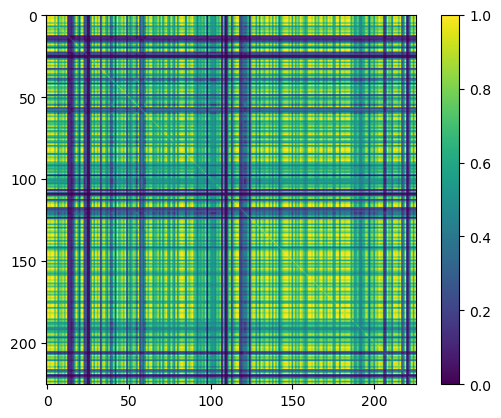

In [209]:
plt.imshow(dist_mat)
plt.colorbar()

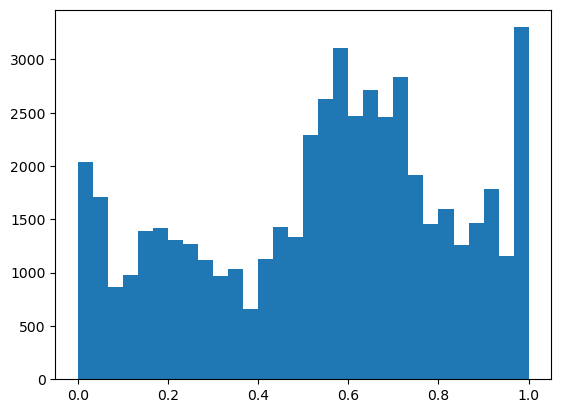

In [210]:
_ = plt.hist(dist_mat.flatten(), bins=30)

In [219]:
model = TSNE(n_components=2, perplexity=1, metric='precomputed', init='random')
kmeans = KMeans(n_clusters=4)

points = model.fit_transform(dist_mat)
points_class = kmeans.fit_predict(points)

df_dict = {'TSNE1': points[:,0], 'TSNE2': points[:,1],
           'cluster': points_class.astype(str),
           'median': median_data, 'count': count_data}

df = pd.DataFrame(df_dict)

/home/ntolley/anaconda3/envs/sfn_2023/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'TSNE2')

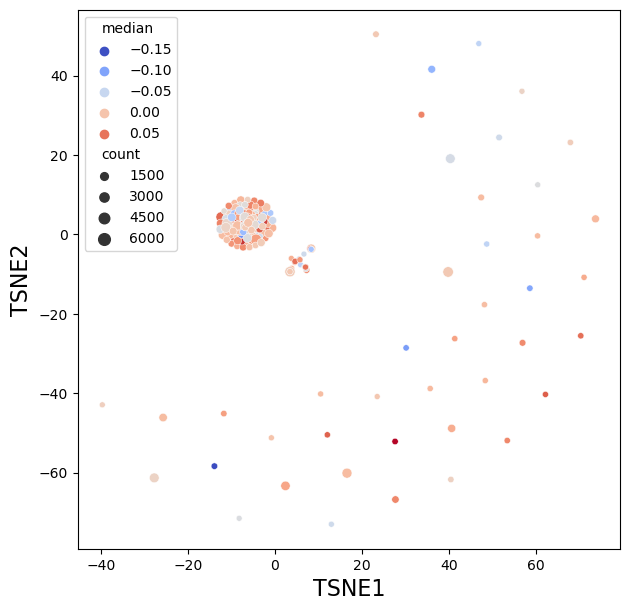

In [220]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', size='count', hue='median', palette='coolwarm')
plt.xlabel('TSNE1', fontsize=16)
plt.ylabel('TSNE2', fontsize=16)

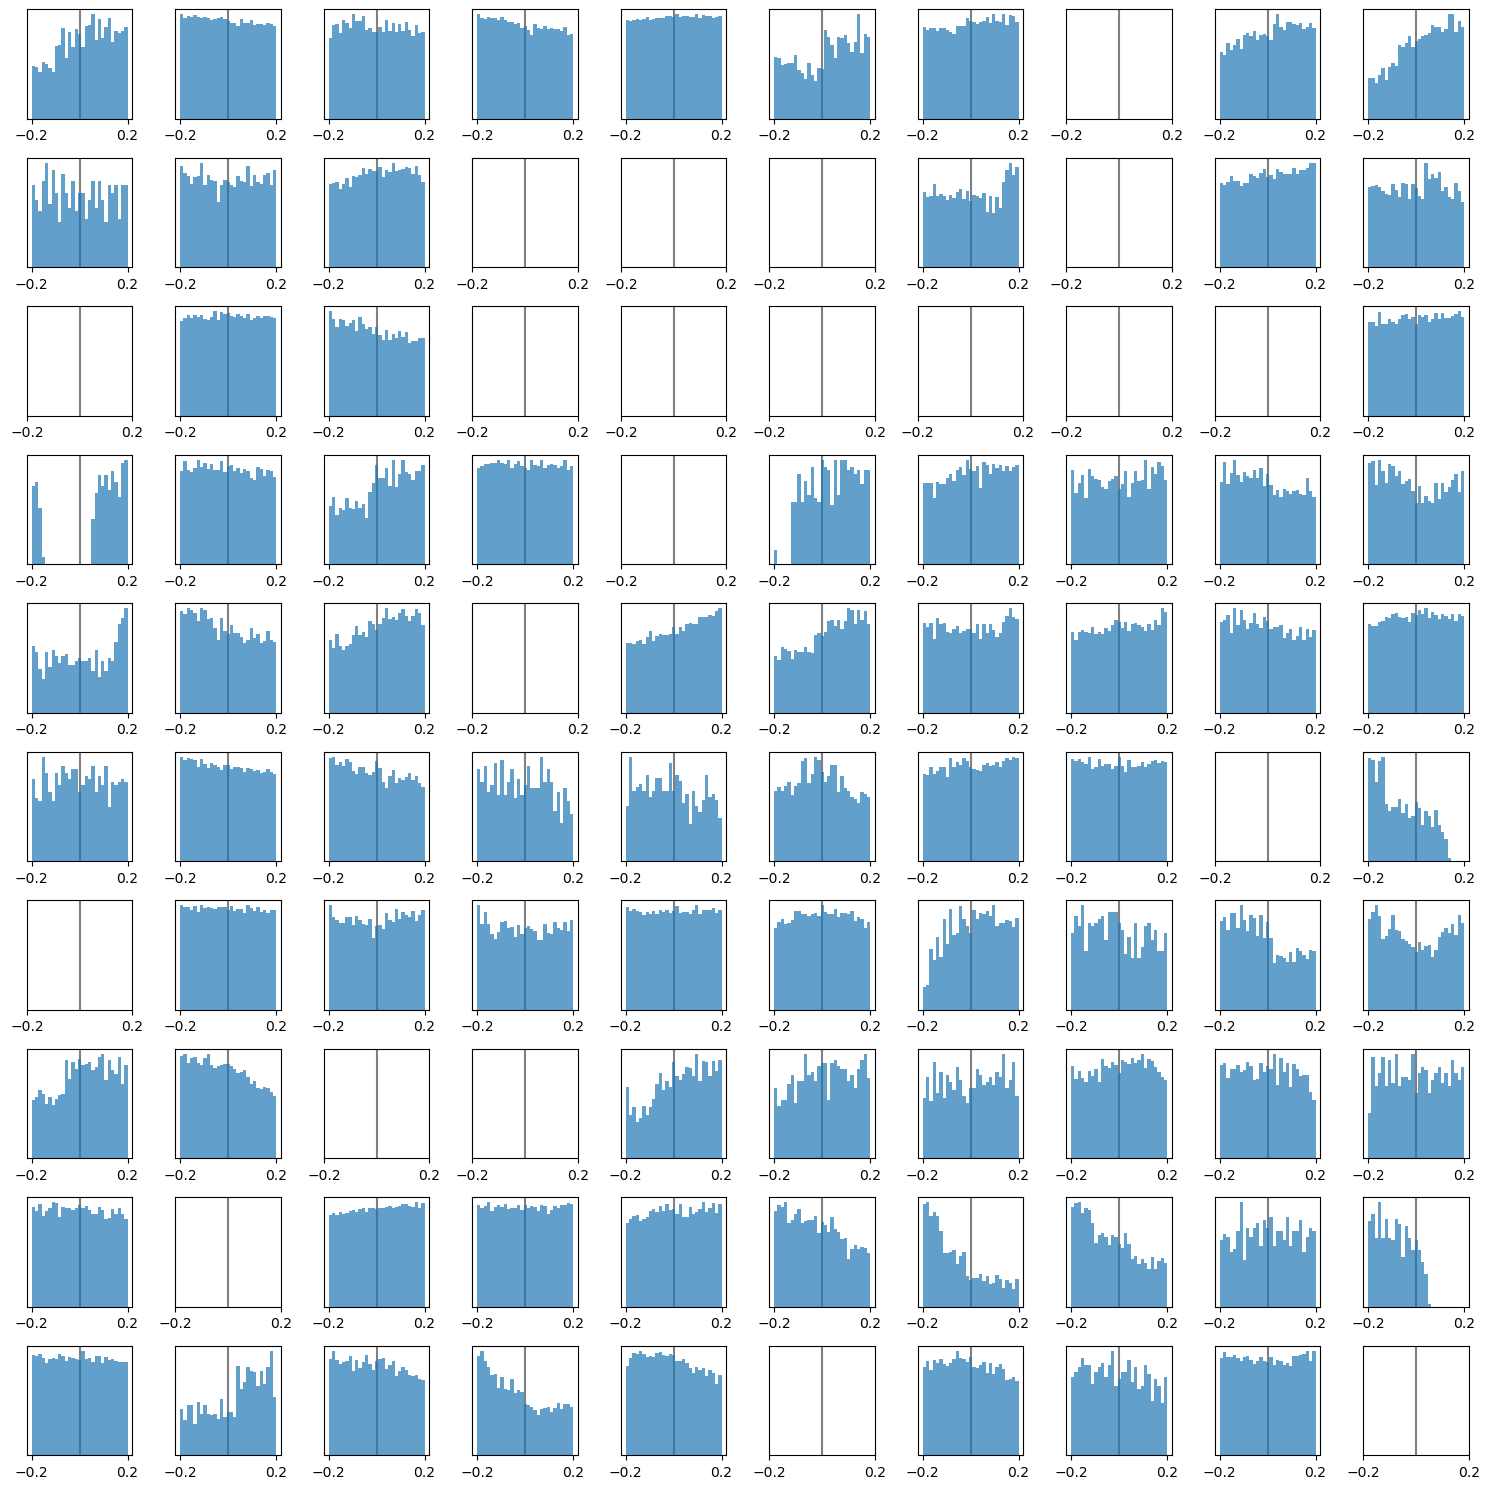

In [46]:
area_color = {'MI': 'C0', 'PMd': 'C1'}

wstart, wstop = -0.2, 0.2
bins = np.linspace(-0.2, 0.2, 30)
plt.figure(figsize=(15,15))
for plot_idx, unit_idx in enumerate(range(0, 100)):
    plt.subplot(10,10,plot_idx+1)
    # _ = plt.hist(np.concatenate(st_data_stmv[unit_idx]) + wstart, bins=bins, alpha=0.4, density=True, color='k')
    _ = plt.hist(np.concatenate(st_data[unit_idx]) + wstart, bins=bins, alpha=0.7, density=True)
    
    # _ = plt.hist(np.concatenate(st_data_cond1[unit_idx]) + wstart, bins=bins, color='C0', alpha=0.7, density=True)
    # _ = plt.hist(np.concatenate(st_data_cond2[unit_idx]) + wstart, bins=bins, color='C1', alpha=0.7, density=True)
    
    plt.axvline(x=0, color='grey', zorder=-1100)
    plt.xticks([wstart, wstop])
    plt.yticks([])
plt.tight_layout()